In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm
import string

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.input_data import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [5]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [6]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [7]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'dlPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [8]:
dz = pd.concat([dx, dy])
del dx, dy
dz

group
GA01     no_stim
GA35     no_stim
GA26     no_stim
GA02     no_stim
GA18     no_stim
...          ...
GP62  dlPFC_cTBS
GP63     M1_cTBS
GP65     M1_cTBS
GP66  dlPFC_cTBS
GP67  dlPFC_cTBS

[76 rows x 1 columns]

---

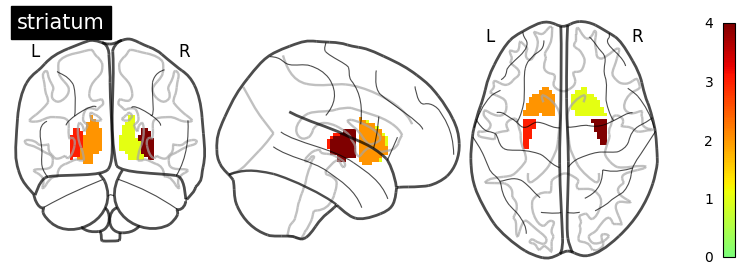

In [9]:
imgs = {}
roi = 'striatum'
imgs[roi] = image.load_img(
    join(dir_mask,'mask.HO_putamen+HO_caudate-y=0.thr50-1mm.nii')
)
plotting.plot_glass_brain(imgs[roi], title=roi, cmap=cm.jet, colorbar=True)

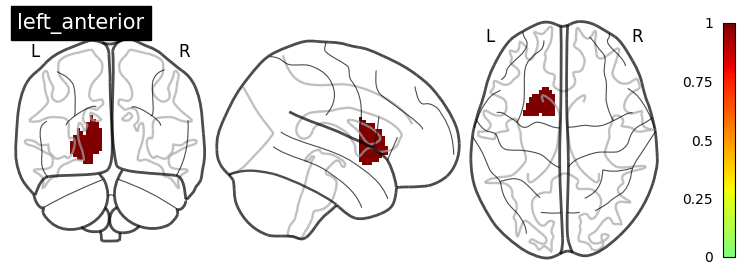

In [10]:
roi = 'left_anterior'
imgs[roi] = image.math_img(
    img1=imgs['striatum']
    , formula='img1==2'
)
plotting.plot_glass_brain(imgs[roi], title=roi, cmap=cm.jet, colorbar=True)

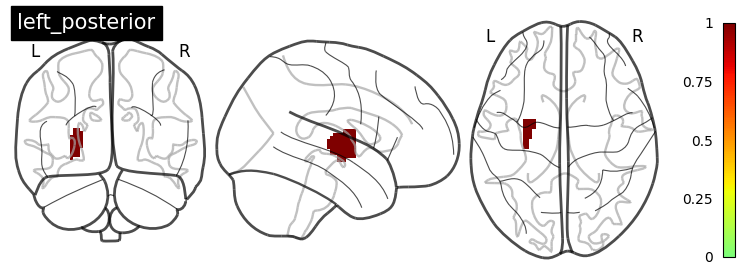

In [11]:
roi = 'left_posterior'
imgs[roi] = image.math_img(
    img1=imgs['striatum']
    , formula='img1==3'
)
plotting.plot_glass_brain(imgs[roi], title=roi, cmap=cm.jet, colorbar=True)

In [12]:
del imgs['striatum']
imgs

{'left_anterior': <nibabel.nifti1.Nifti1Image at 0x7fa368613e20>,
 'left_posterior': <nibabel.nifti1.Nifti1Image at 0x7f9f2780c9a0>}

---

In [32]:
p_thresh = 5.e-2
thresh = stats.norm.isf(0.5*p_thresh)

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



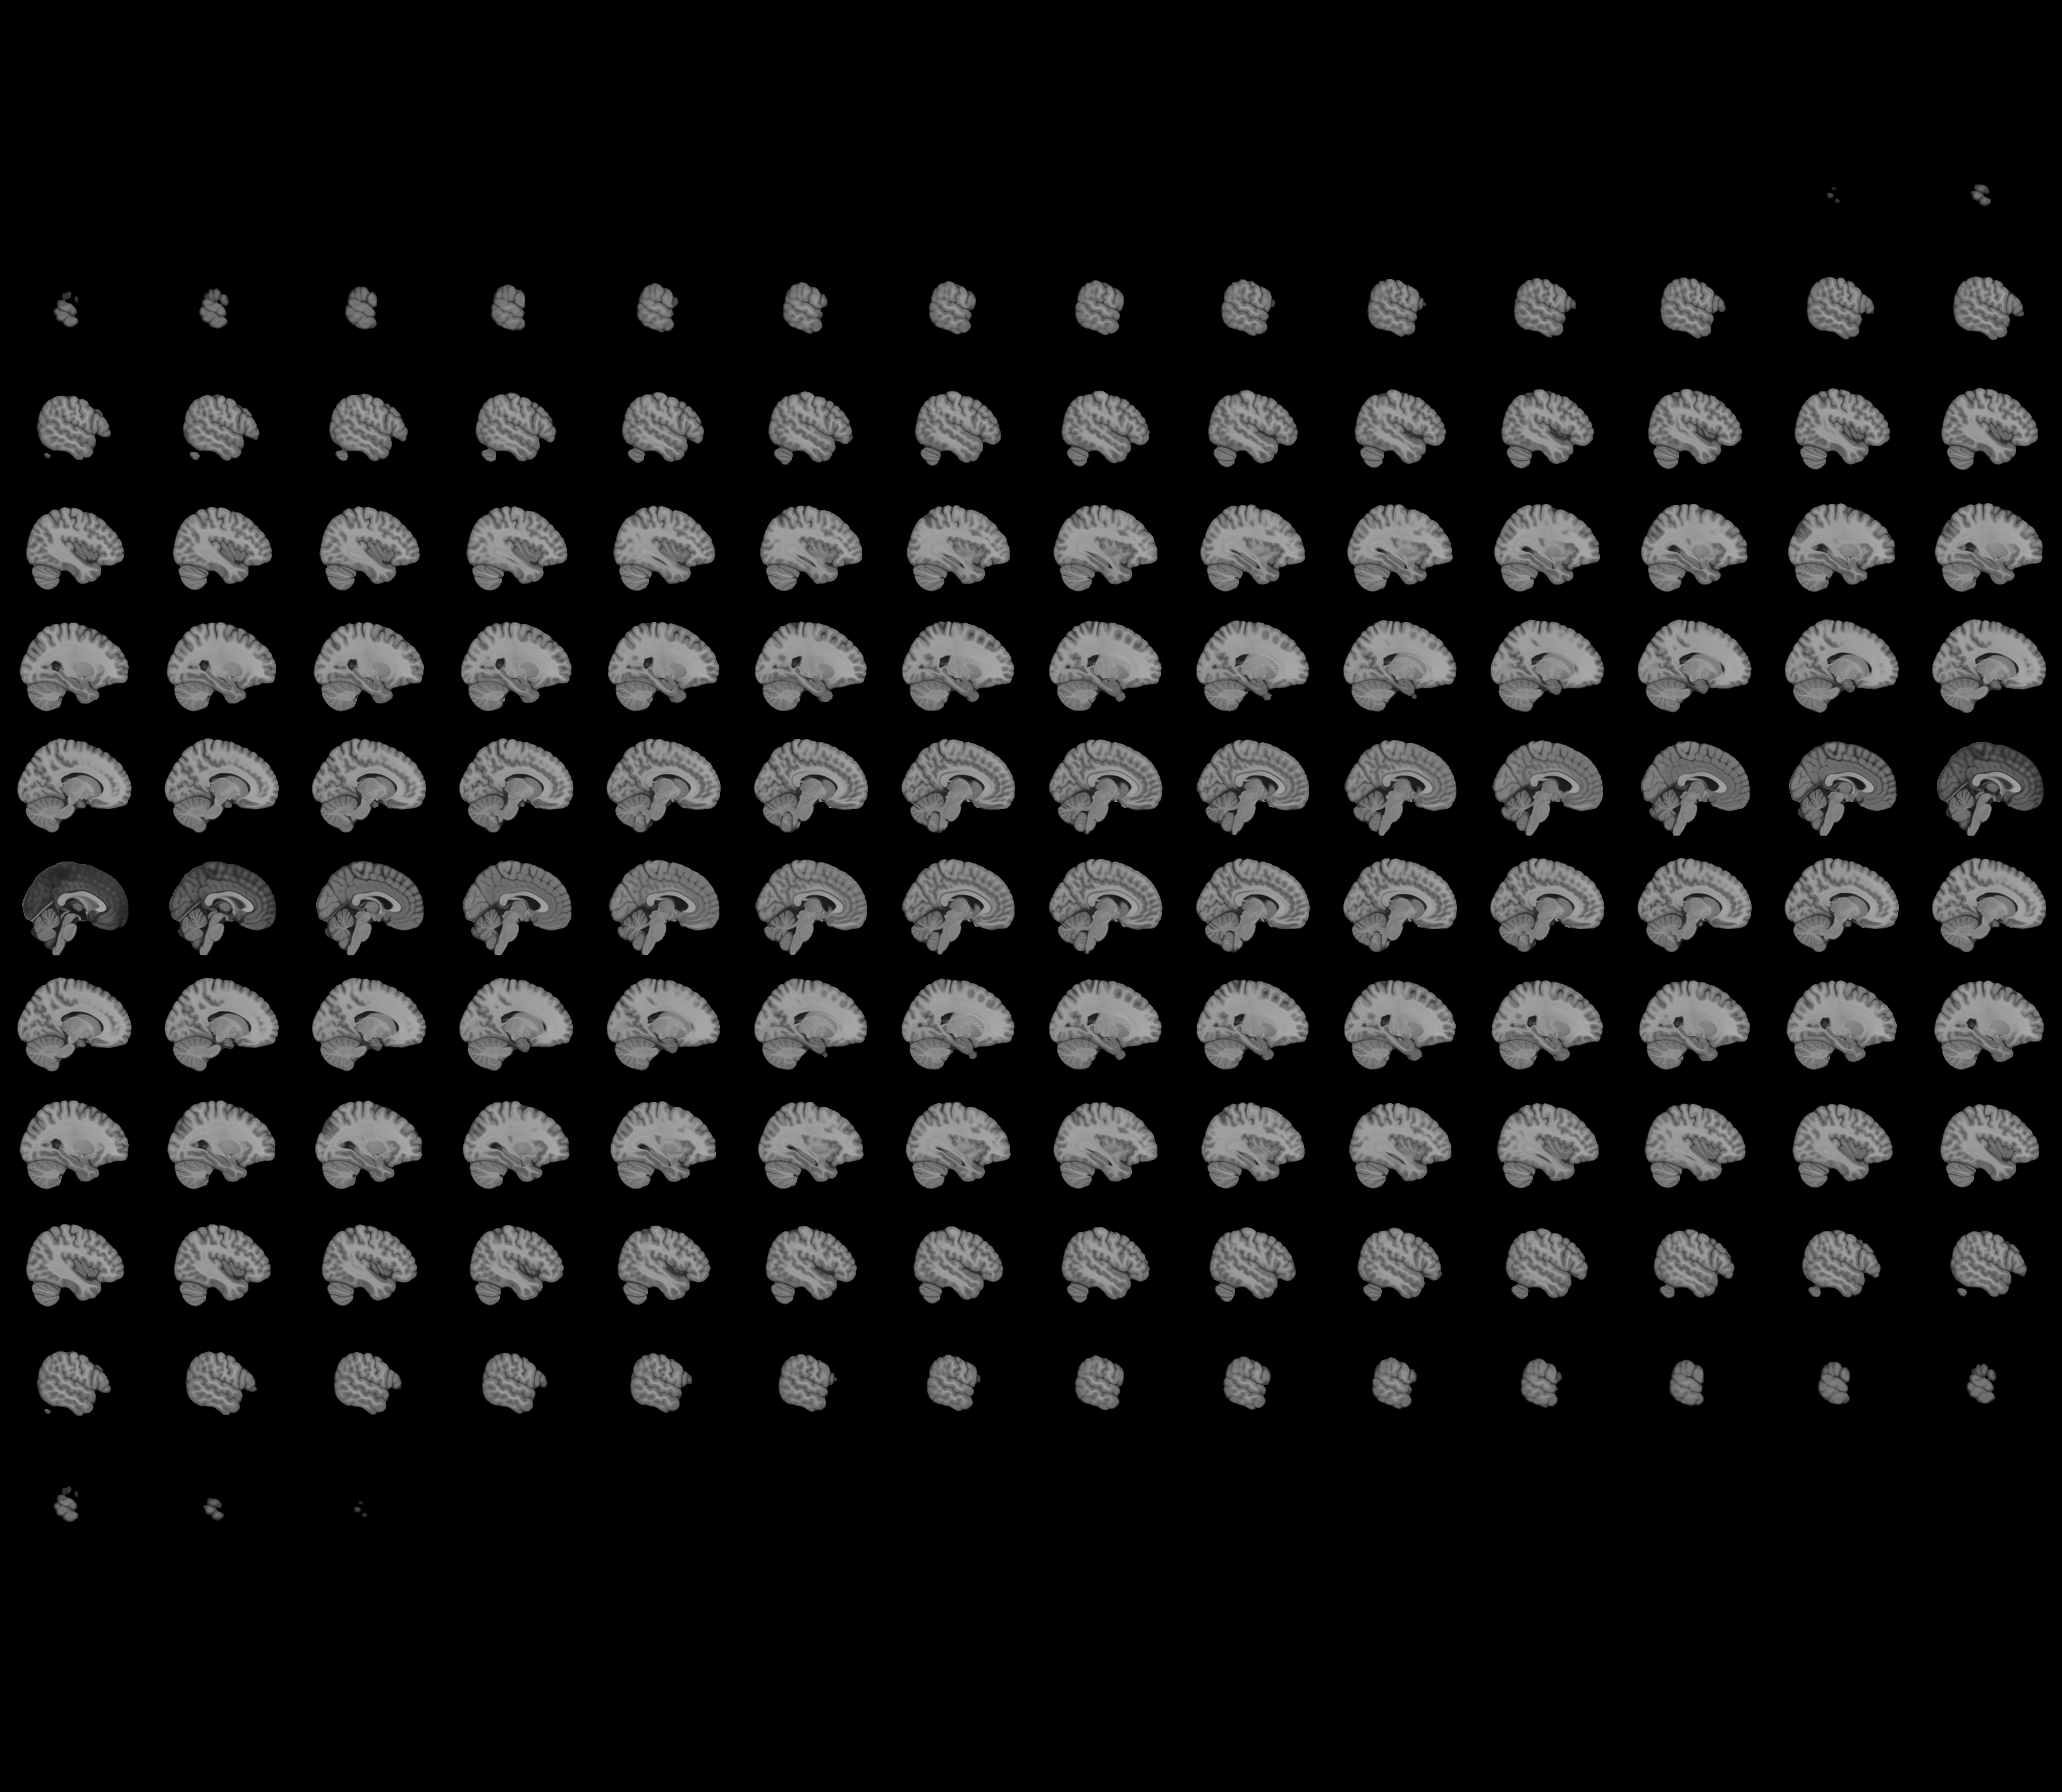
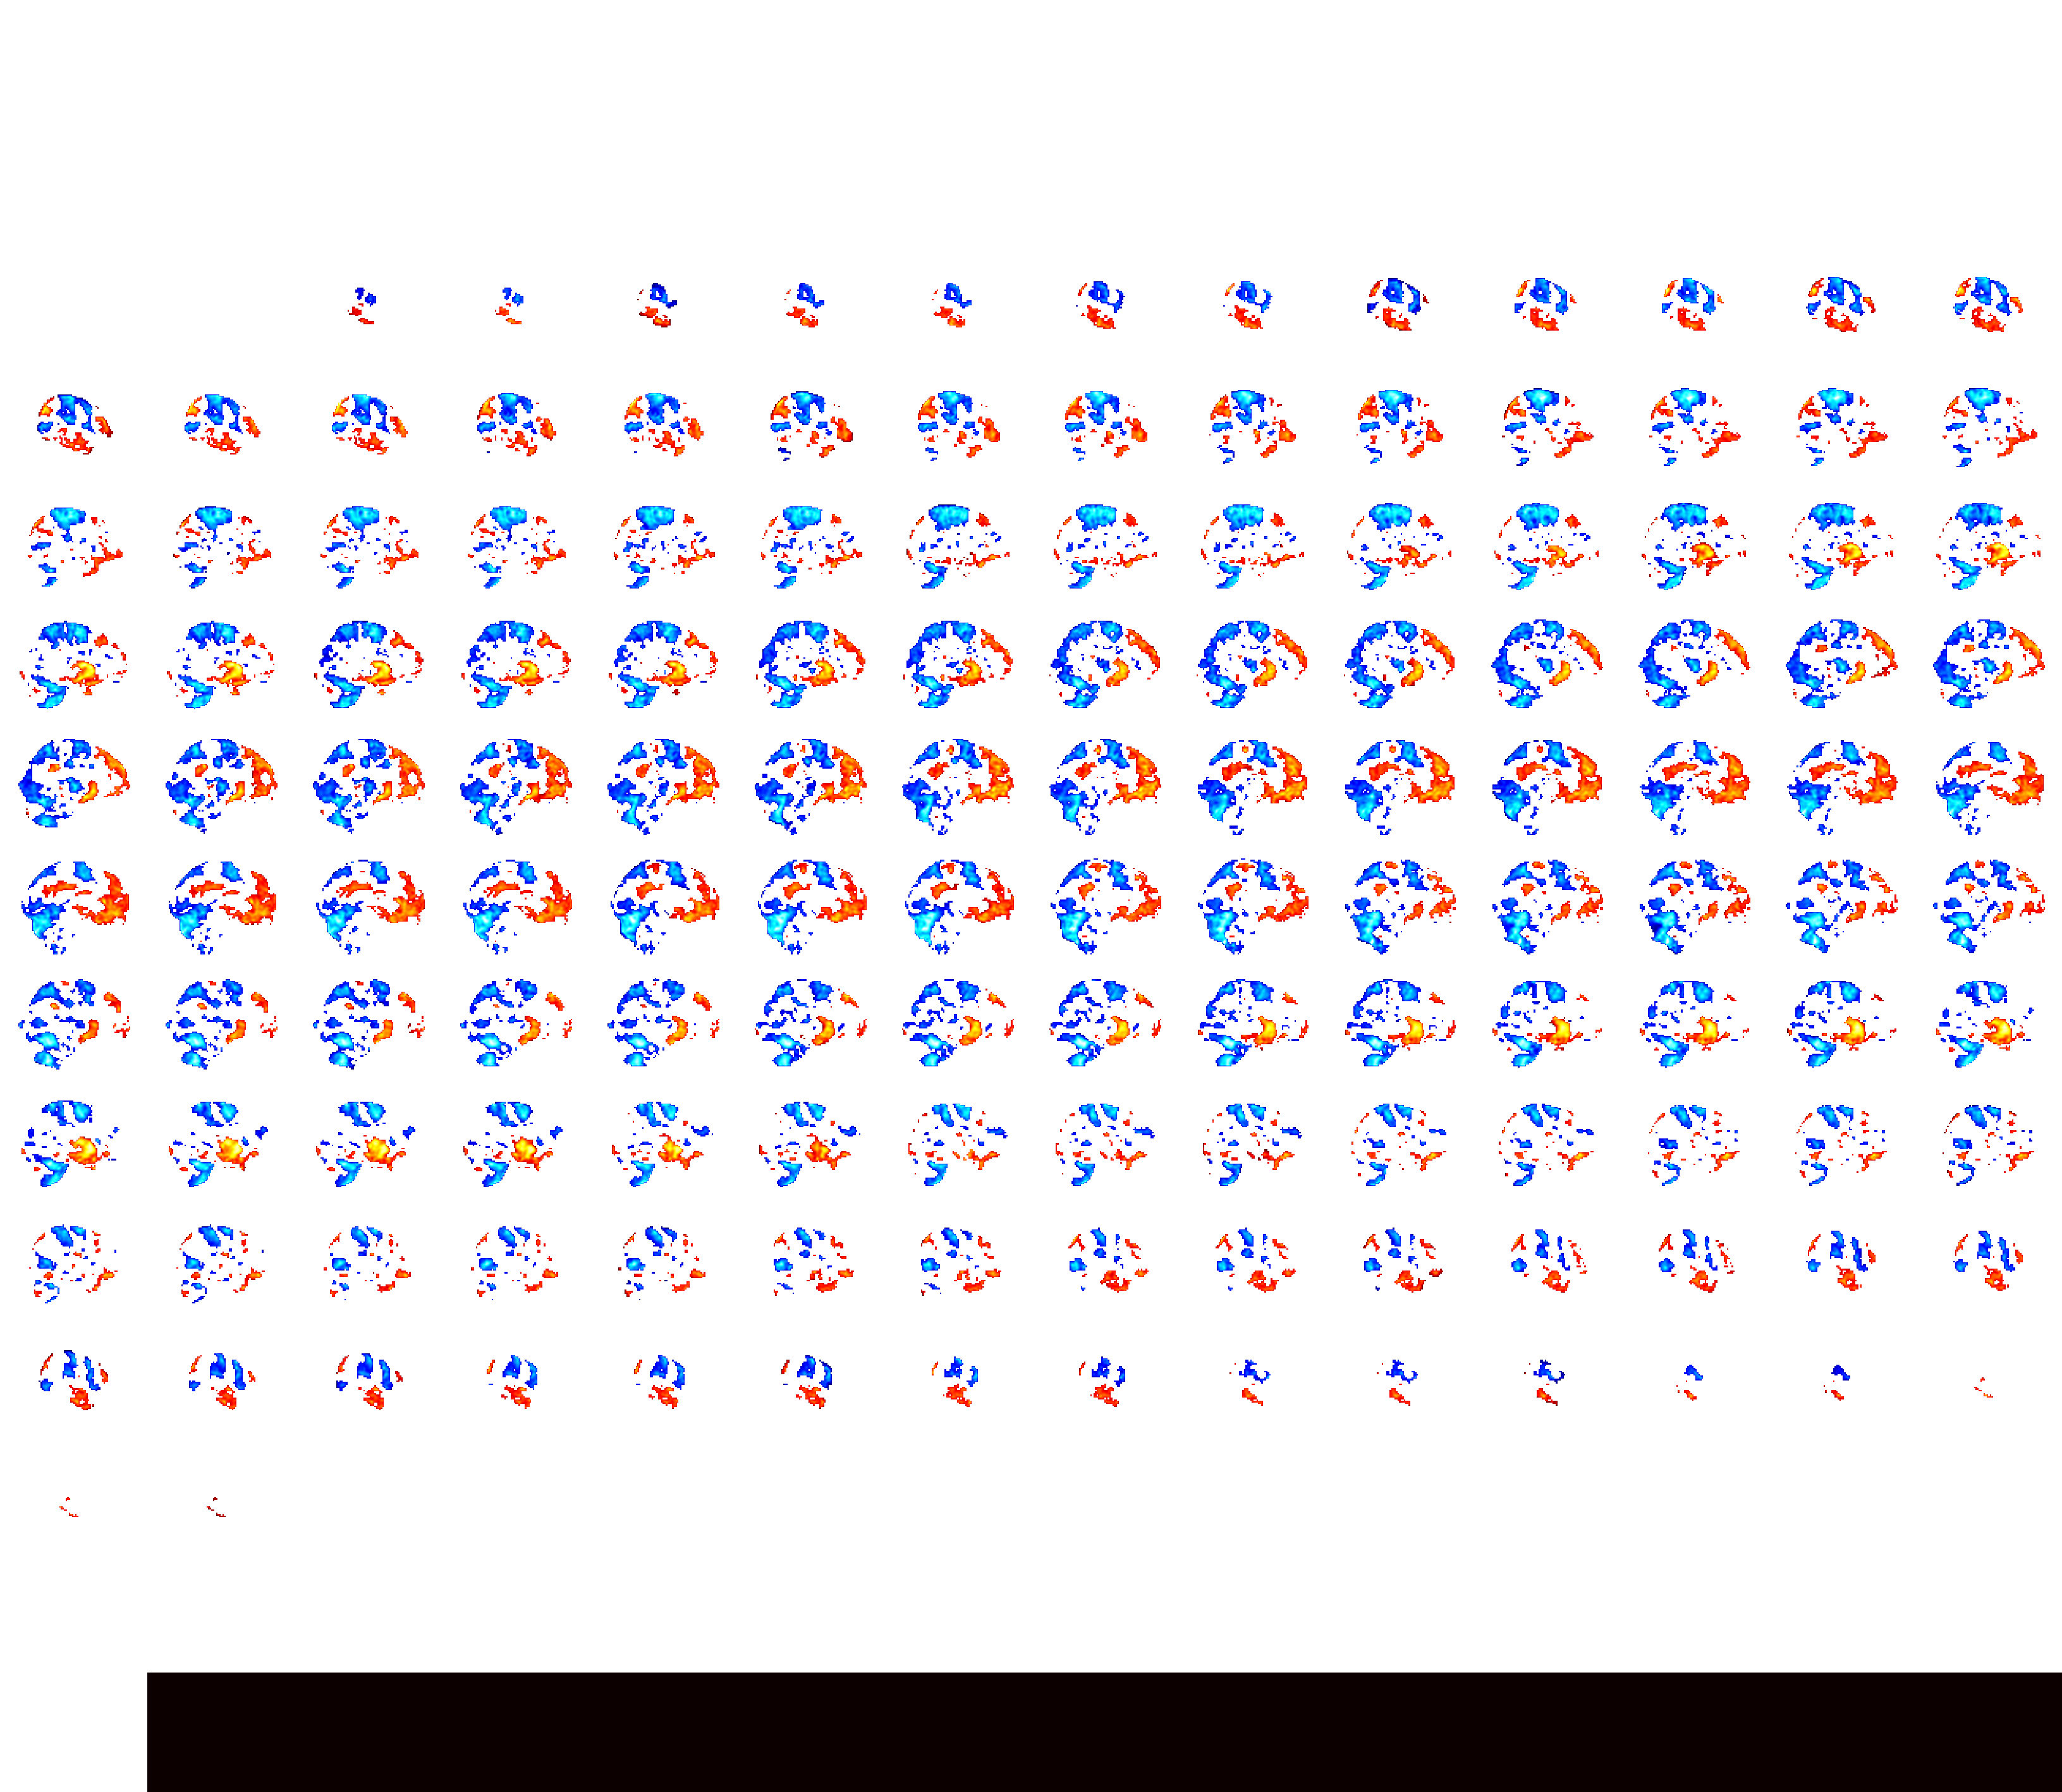

In [33]:
group = 'dlPFC_cTBS'
fname_Zscr = glob(join(dir_stat,'%s.Zscr.n??.nii'%group))[0]
plotting.view_img(
    fname_Zscr
    , threshold=thresh
    , vmax=6
)

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



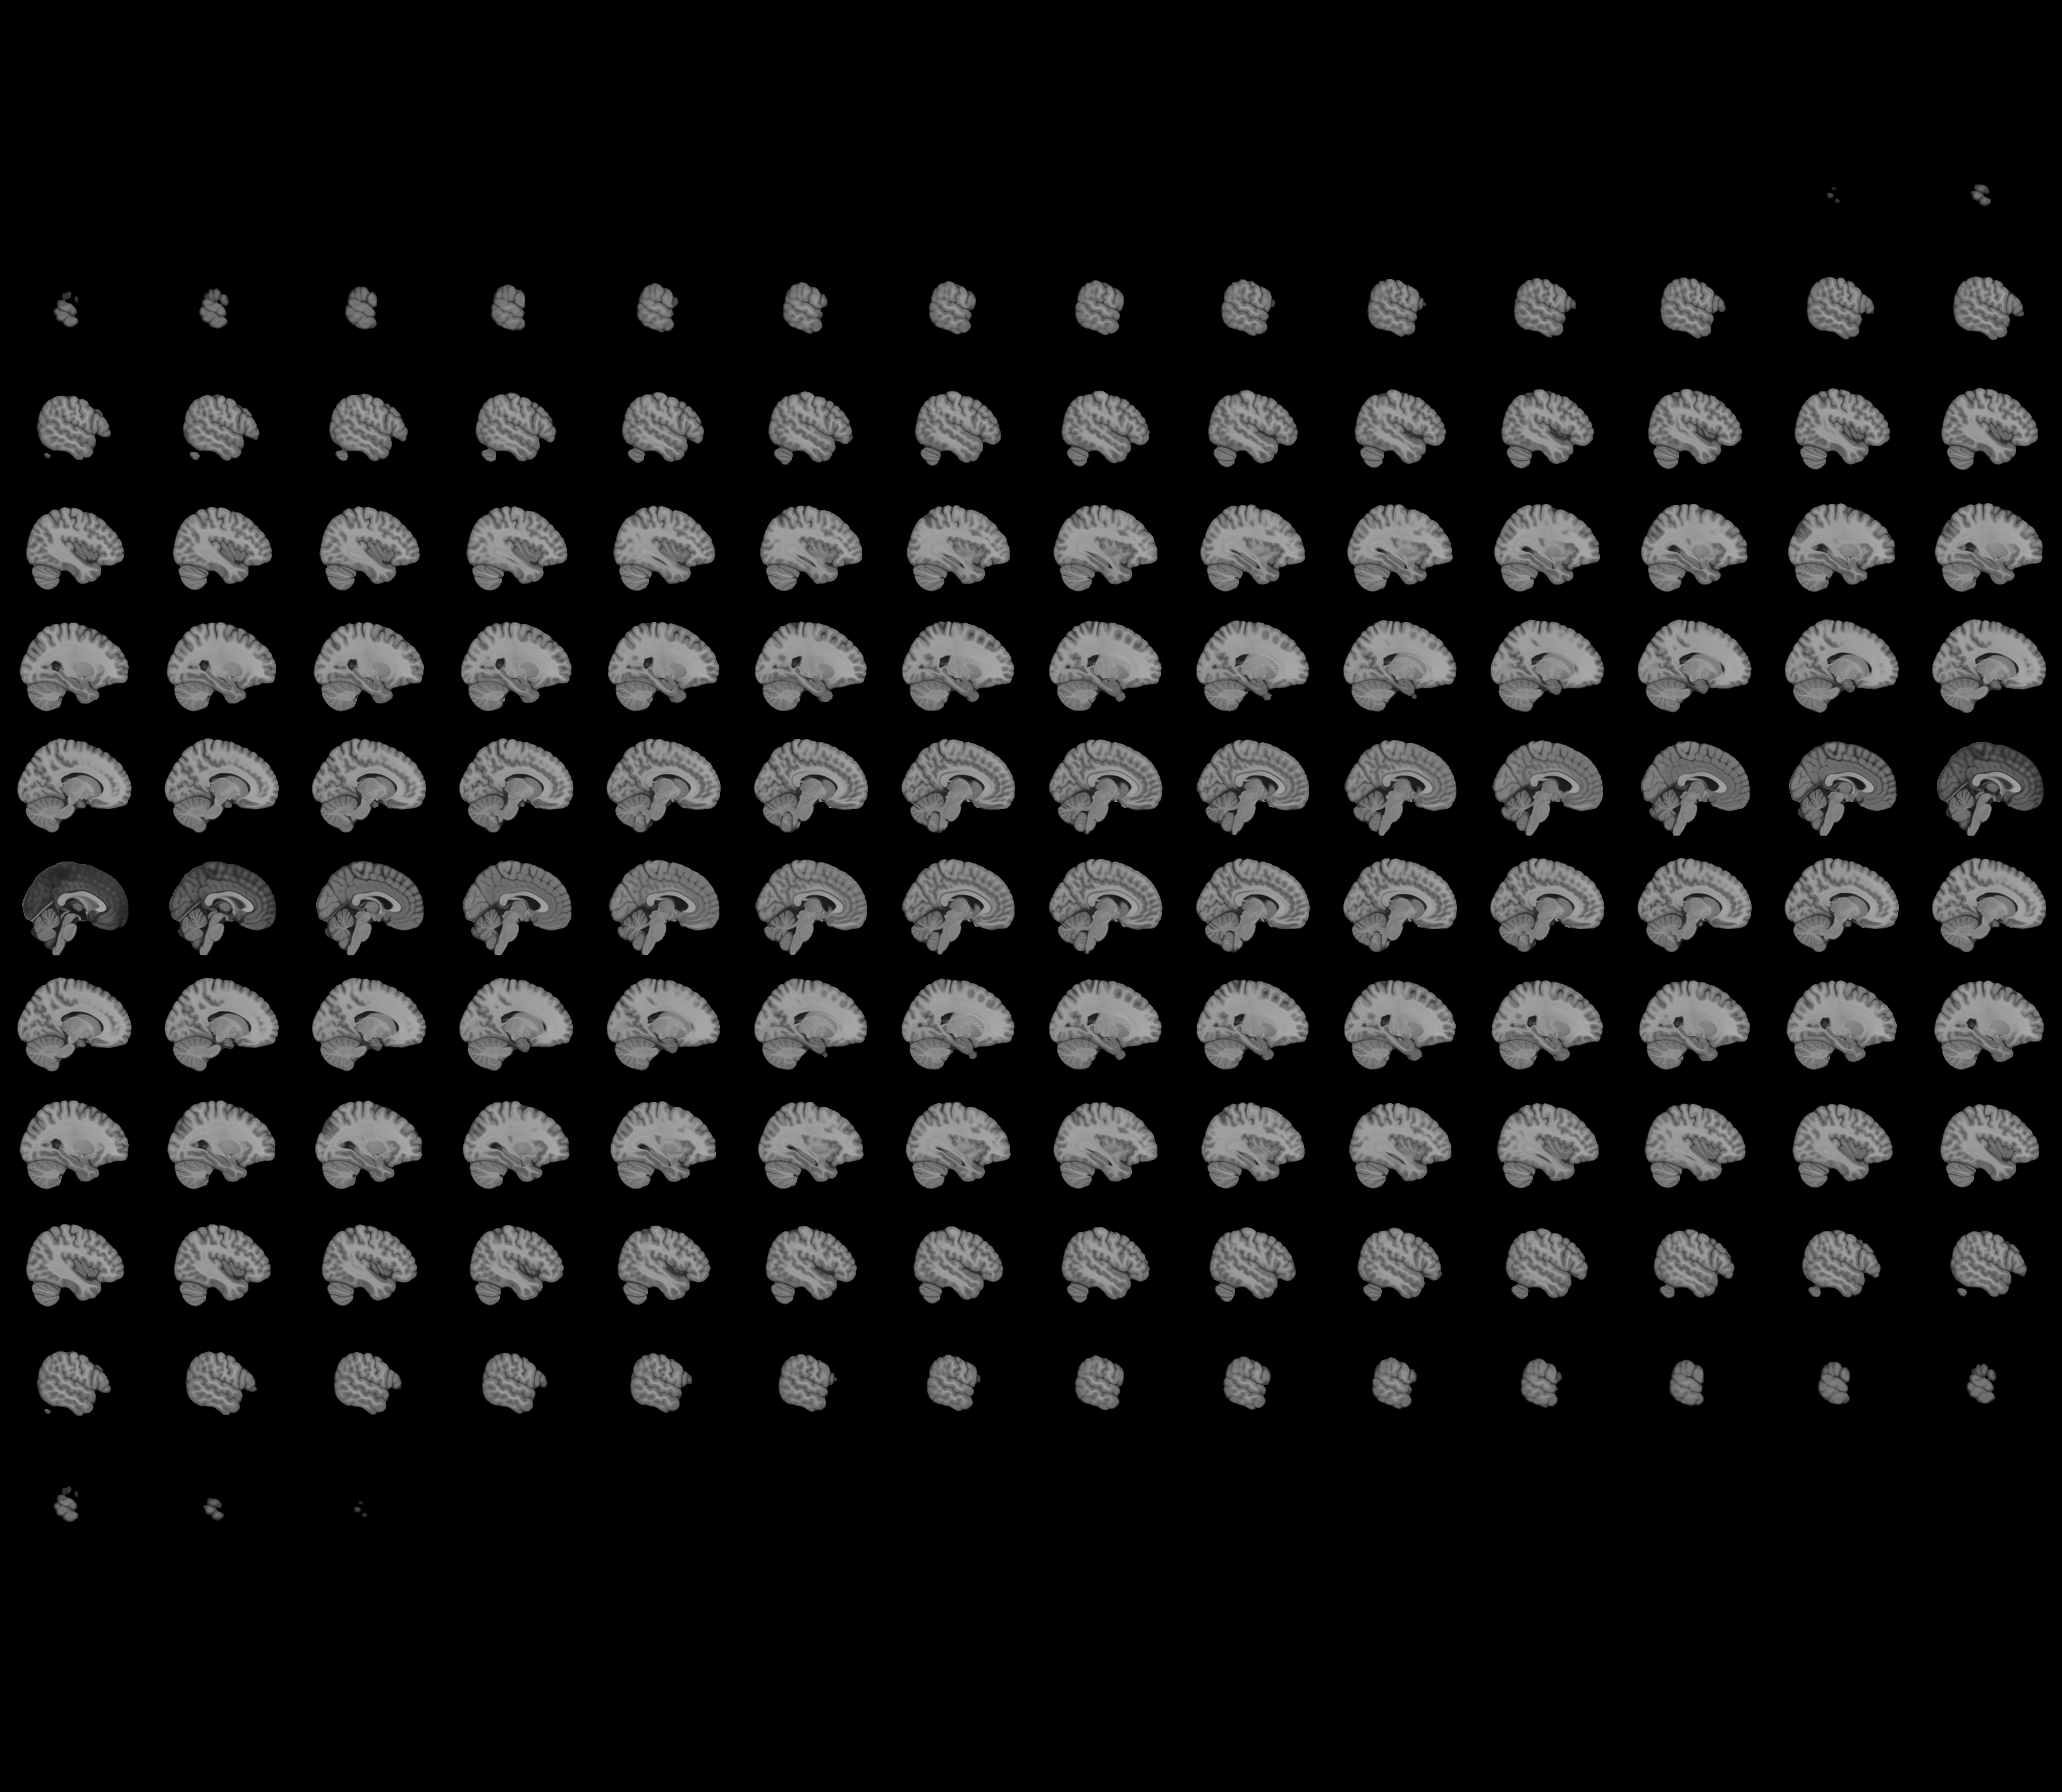
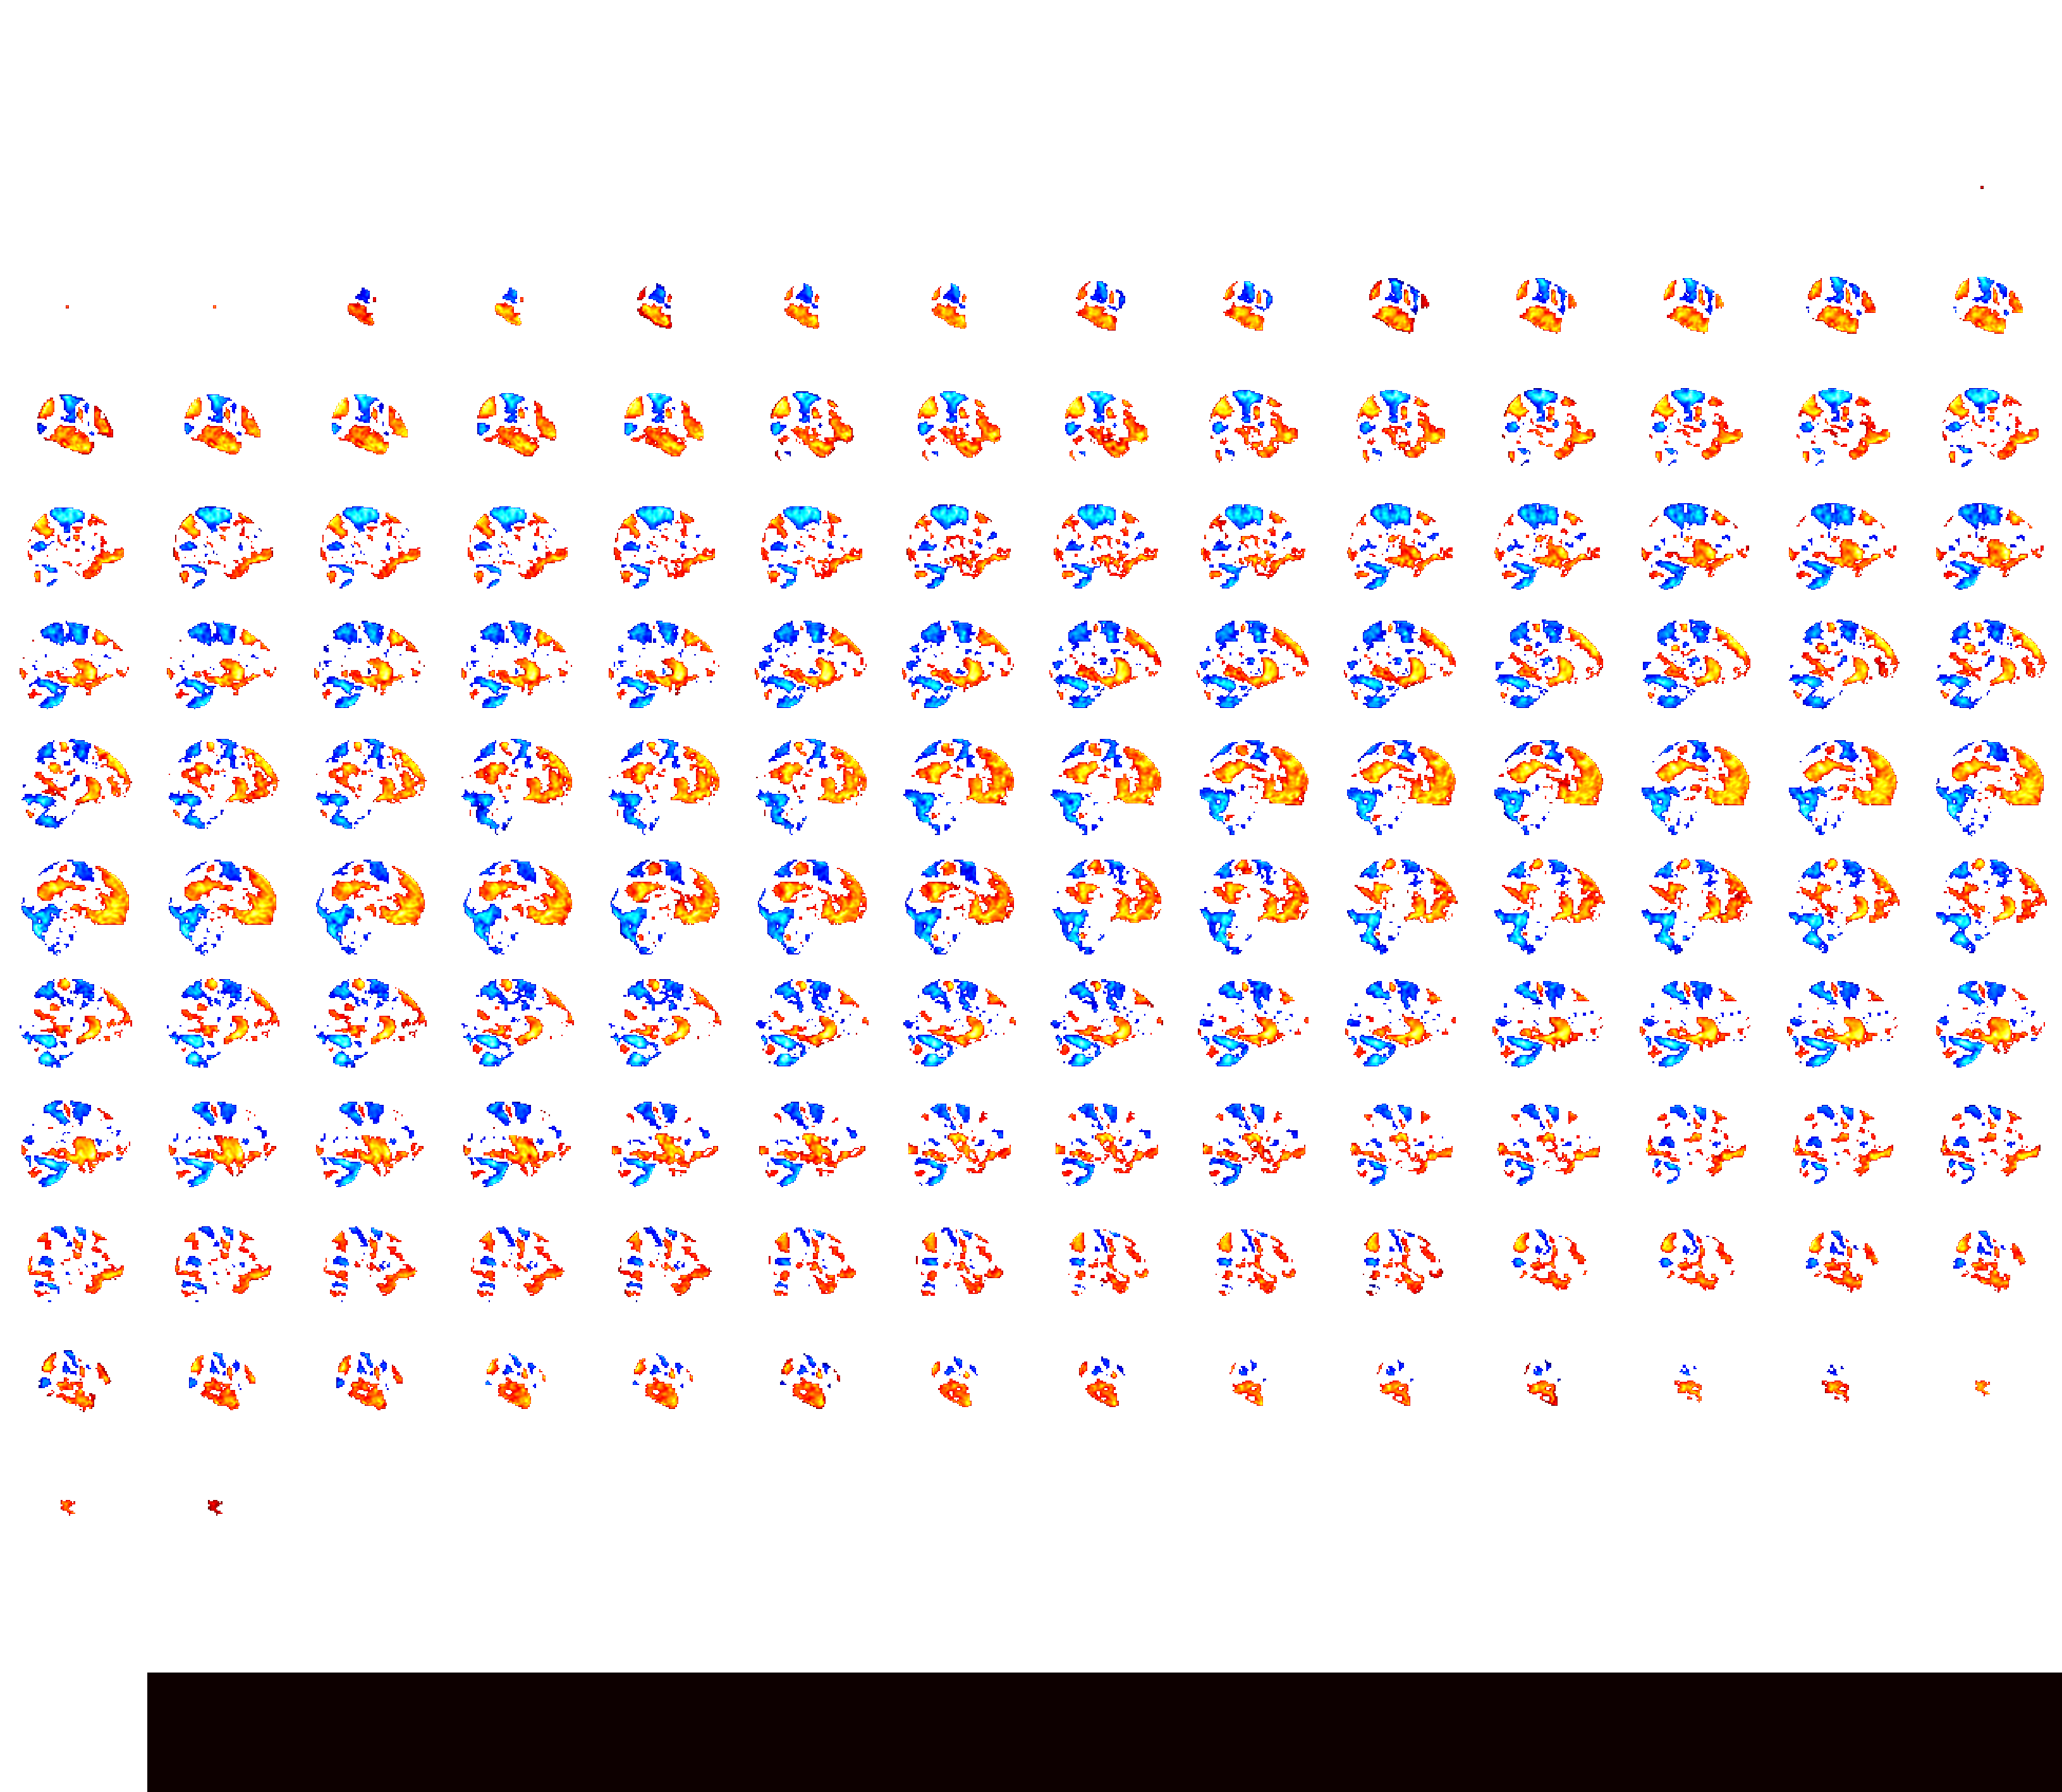

In [34]:
group = 'M1_cTBS'
fname_Zscr = glob(join(dir_stat, '%s.Zscr.n??.nii'%group))[0]
plotting.view_img(
    fname_Zscr
    , threshold=thresh
    , vmax=6
)

In [35]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7]
view_cut['axial'] = [2]

---

/tmp/ipykernel_199832/1351251172.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


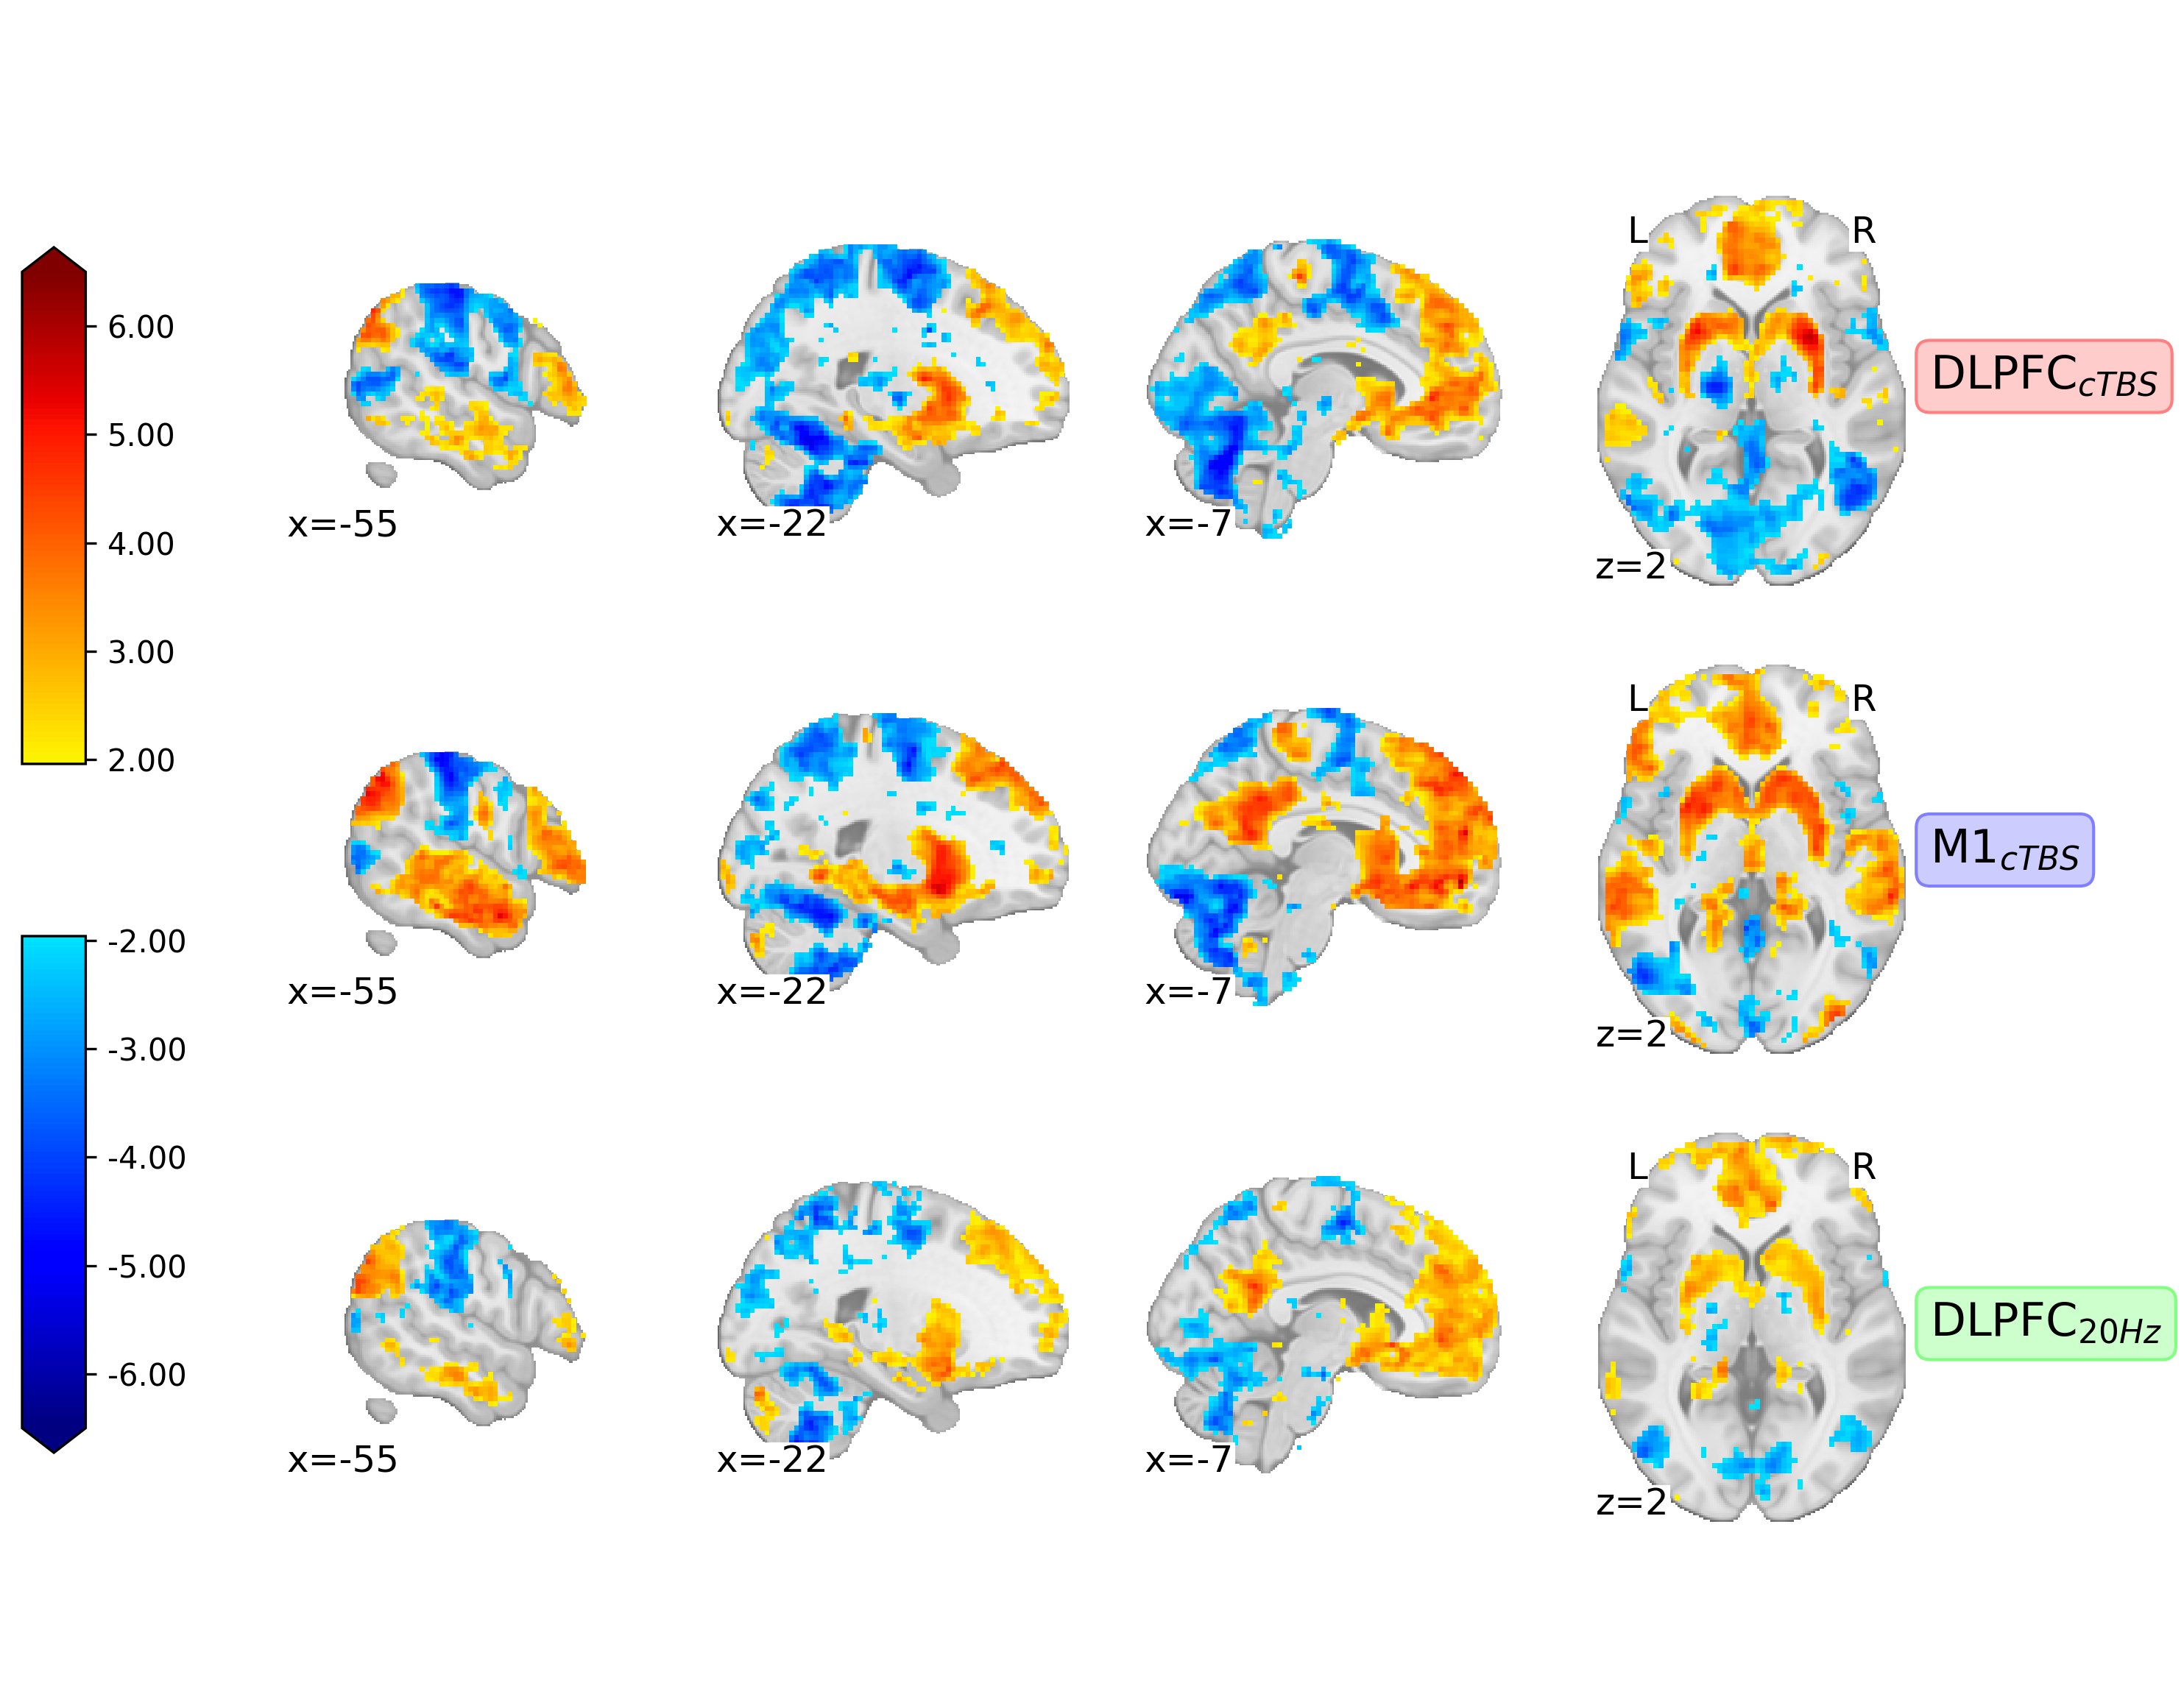

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(2.4*4,2.6*3), dpi=300)

for ii, group in enumerate(['dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz']):
    for jj, coord in enumerate(view_cut['sagittal']):
        ax = axs[ii][jj]
        fname_Zscr = glob(join(dir_stat,'%s.Zscr.n??.nii'%group))[0]
        
#         ## positive
#         img_stat = image.math_img(
#             img1=fname_Zscr
#             , formula='(img1>0) * img1'
#         )
        
        ## positive & negative
        img_stat = fname_Zscr
        
        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='x'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )
    for kk, coord in enumerate(view_cut['axial']):
        ax = axs[ii][jj+1+kk]
#         ## positive
#         img_stat = image.math_img(
#             img1=fname_Zscr
#             , formula='(img1>0) * img1'
#         )
        
        ## positive & negative
        img_stat = fname_Zscr
        
        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='z'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )

## 최대 최소 설정
vmax = 6.5
vmin = -6.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.55, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

################
## lower cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=vmin, vmax=-thresh)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.15, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)

## titles
fig.text(
    0.9, 0.775, r'DLPFC$_{cTBS}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(1., 0.5, 0.5)
        , fc=(1., 0.8, 0.8)
    )
)
fig.text(
    0.9, 0.5, r'M1$_{cTBS}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(0.5, 0.5, 1)
        , fc=(0.8, 0.8, 1)
    )
)

fig.text(
    0.9, 0.225, r'DLPFC$_{20Hz}$'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(0.5, 1, 0.5)
        , fc=(0.8, 1, 0.8)
    )
)

fig.tight_layout()

In [31]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-a.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)

---

In [13]:
## group data
a = glob('/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/GA??/Rew#1_Coef.nii')
p = glob(join(dir_stat,'GP??/Rew#1_Coef.nii'))
list_fname = np.concatenate([a,p])

In [14]:
df = pd.DataFrame()

for ii, (roi, img) in enumerate(imgs.items()):
    for fname in tqdm(list_fname):
        subj = fname.split('/')[-2]
        nn=subj[2:]

        group = dz.loc[subj,'group']
        region = 'DLPFC' if 'dlPFC' in group else ('M1' if 'M1' in group else 'None')
        stim = 'cTBS' if 'cTBS' in group else ('20Hz' if '20Hz' in group else 'None')

        beta = masking.apply_mask(imgs=fname, mask_img=img)
        new_row = pd.Series(
            {
                'subj':subj, 'group':group, 'region':region, 'stim':stim
                , 'roi':roi, 'beta':beta.mean()
            }
        )
        df = pd.concat(
            [df, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )
df.set_index('subj', inplace=True)
df.index.name = None
df

100%|██████████| 76/76 [00:17<00:00,  4.41it/s]


group region  stim             roi      beta
GA01     no_stim   None  None   left_anterior  0.275142
GA35     no_stim   None  None   left_anterior  0.527703
GA26     no_stim   None  None   left_anterior  0.374283
GA02     no_stim   None  None   left_anterior  0.460639
GA18     no_stim   None  None   left_anterior -0.015922
...          ...    ...   ...             ...       ...
GP57  dlPFC_cTBS  DLPFC  cTBS  left_posterior  0.554967
GP55  dlPFC_20Hz  DLPFC  20Hz  left_posterior  0.489632
GP37     M1_cTBS     M1  cTBS  left_posterior  0.245407
GP46  dlPFC_20Hz  DLPFC  20Hz  left_posterior  0.177886
GP40     M1_cTBS     M1  cTBS  left_posterior  0.191207

[152 rows x 5 columns]

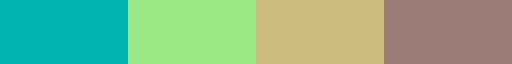

In [15]:
tmp = cm.terrain(np.linspace(0.2, 0.8, 4))
palette = [colors.to_rgba(rgb, alpha=1) for rgb in tmp]

colors.ListedColormap(palette)

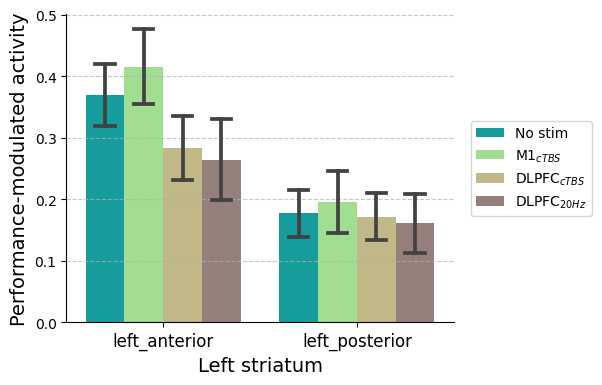

In [42]:
fig, ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    data=df, x='roi', y='beta', hue='group'
    , hue_order=('no_stim', 'M1_cTBS', 'dlPFC_cTBS', 'dlPFC_20Hz')
#     , order=['left_anterior_striatum','left_posterior_striatum']
    , palette=palette
    , errorbar='se', capsize=0.1
    , ax=ax
)
g.set_xlabel('Left striatum', fontsize=14)
g.set_xticklabels(g.get_xticklabels(), fontsize=12, rotation=0)
# g.set_xticklabels(['Anterior','Posterior'], fontsize=12, rotation=0)
g.set_ylabel('Performance-modulated activity', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
g.legend(bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1)
# g.legend(loc='best')
for ii, text in enumerate(g.get_legend_handles_labels()[-1]):
    if ii==0:
        text_new = 'No stim'
    else:
        a, b = text.split('_')
        text_new = r'%s$_{%s}$'%(a.upper(),b)
    g.legend_.texts[ii].set_text(text_new)

# ## Bounding box
# bbox = g.get_position()
# rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
# ax_insert = fig.add_axes(rect)
# nilearn.plotting.plot_roi(
#     img_roi
#     , display_mode='ortho', draw_cross=False
# #     , cut_coords=[0, 40, 10]
#     , axes=ax_insert
# )

sns.despine()

In [43]:
list_label = []
for aa in g.get_legend_handles_labels()[-1]:
    for bb in g.get_xticklabels():
        list_label.append((aa,bb.get_text()))

list_rect = []
list_line = []
for child in g.get_children():
    if type(child) is patches.Rectangle:
        list_rect.append(child)
    elif type(child) is lines.Line2D:
        list_line.append(child)
list_rect = list_rect[:8]
list_line = list_line[:3*8]

dict_rect = {}
for label, rect in zip(list_label, list_rect):
    print(label, rect)
    dict_rect[label] = rect

dict_line = {}
for ii, label in enumerate(list_label):
    for jj, line in enumerate(list_line[ii*3:(ii+1)*3]):
        kk = 'mid' if jj==0 else ('bottom' if jj==1 else ('top' if jj==2 else 'invalid'))
#         print(label, line)
        dict_line[(*(label), kk)] = line

del list_label, list_rect, list_line

('no_stim', 'left_anterior') Rectangle(xy=(-0.4, 0), width=0.2, height=0.369599, angle=0)
('no_stim', 'left_posterior') Rectangle(xy=(0.6, 0), width=0.2, height=0.177322, angle=0)
('M1_cTBS', 'left_anterior') Rectangle(xy=(-0.2, 0), width=0.2, height=0.415308, angle=0)
('M1_cTBS', 'left_posterior') Rectangle(xy=(0.8, 0), width=0.2, height=0.195127, angle=0)
('dlPFC_cTBS', 'left_anterior') Rectangle(xy=(2.77556e-17, 0), width=0.2, height=0.2839, angle=0)
('dlPFC_cTBS', 'left_posterior') Rectangle(xy=(1, 0), width=0.2, height=0.17196, angle=0)
('dlPFC_20Hz', 'left_anterior') Rectangle(xy=(0.2, 0), width=0.2, height=0.263961, angle=0)
('dlPFC_20Hz', 'left_posterior') Rectangle(xy=(1.2, 0), width=0.2, height=0.16092, angle=0)


left_anterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.4516 (ns)
no_stim (30) vs dlPFC_cTBS (17) (greater):
0.1117 (ns)
no_stim (30) vs dlPFC_20Hz (12) (greater):
0.0778 (ns)
M1_cTBS (17) vs dlPFC_cTBS (17) (greater):
0.0509 (ns)
M1_cTBS (17) vs dlPFC_20Hz (12) (greater):
0.0347 (*)
dlPFC_cTBS (17) vs dlPFC_20Hz (12) (less):
0.6710 (ns)

left_posterior
no_stim (30) vs M1_cTBS (17) (two-sided):
0.7566 (ns)
no_stim (30) vs dlPFC_cTBS (17) (greater):
0.4210 (ns)
no_stim (30) vs dlPFC_20Hz (12) (greater):
0.4227 (ns)
M1_cTBS (17) vs dlPFC_cTBS (17) (greater):
0.3210 (ns)
M1_cTBS (17) vs dlPFC_20Hz (12) (greater):
0.2976 (ns)
dlPFC_cTBS (17) vs dlPFC_20Hz (12) (less):
0.5703 (ns)



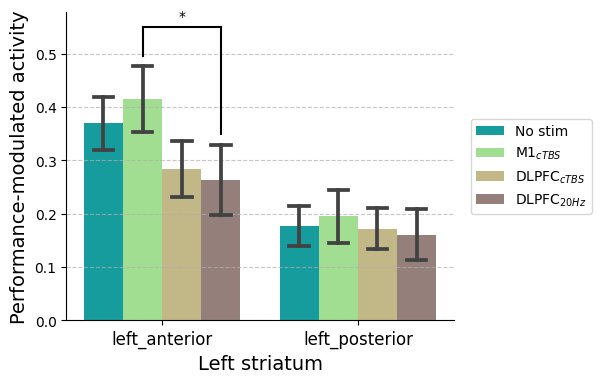

In [44]:
yApart = 0.02
tmp = [0.55]
cnt = 0

list_ = g.get_legend_handles_labels()[-1]
for roi in df.roi.unique():
    print(roi)
    for ii, g1 in enumerate(list_):
        for g2 in list_[ii+1:]:
            kk = 'less' if 'dlPFC' in g1 else ('greater' if 'dlPFC' in g2 else 'two-sided')

            a = df[(df.group==g1)&(df.roi==roi)].beta
            b = df[(df.group==g2)&(df.roi==roi)].beta
            print('%s (%d) vs %s (%d) (%s):'%(g1,len(a),g2,len(b),kk))

            tval, pval = stats.ranksums(
                a.values.astype(float), b.values.astype(float)
                , alternative = kk
            )
            print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
            
            if pval < 0.05:
                [x10,y10],[x11,y11] = np.array(dict_rect[(g1,roi)].get_bbox())
                x1 = (x10+x11)*0.5
                [x20,y20],[x21,y21] = np.array(dict_rect[(g2,roi)].get_bbox())
                x2 = (x20+x21)*0.5
                
                yUEdge = tmp[cnt]
                g.plot([x1, x1], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
                g.plot([x2, x2], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
                g.plot([x1, x2], [yUEdge, yUEdge], 'k-')
                g.text(
                    (x1+x2)*0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
                    , ha='center', va='center', rotation=0, size=10
                )
                cnt += 1
    print('')
fig

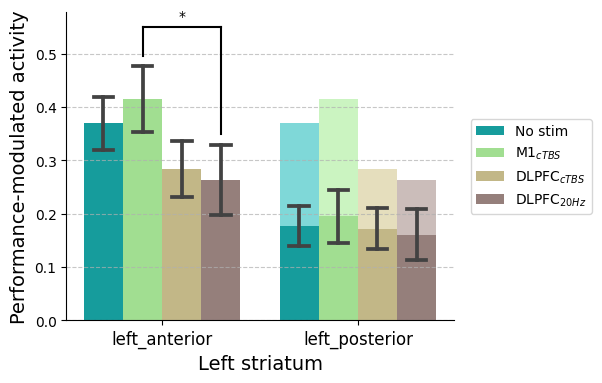

In [45]:
for ii, legend in enumerate(g.get_legend_handles_labels()[-1]):
    width = dict_rect[(legend,'left_anterior')].get_width()
    h1 = dict_rect[(legend,'left_anterior')].get_height()
    h2 = dict_rect[(legend,'left_posterior')].get_height()
    height = h1 - h2
    x2 = dict_rect[(legend,'left_posterior')].get_x()
    xy = (x2, h2)
    color = (*palette[ii][:3], 0.5)
    g.add_patch(patches.Rectangle(
        xy=xy, width=width, height=height
        , facecolor=color, edgecolor=None
#         , hatch='o'
    ))
fig

In [46]:
r1, r2 = 'anterior', 'posterior'
print("%s vs. %s"%(r1, r2))

list_ = g.get_legend_handles_labels()[-1]
for ii, g1 in enumerate(list_):
    for g2 in list_[ii+1:]:
        print('%s vs %s'%(g1,g2))
        kk = 'greater' if 'M1' in g1 else ('less' if 'M1' in g2 else 'two-sided')
        
        a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
        b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

        c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
        d = df[(df.group==g2)&(df.roi=='left_posterior')].beta

        tval, pval = stats.ttest_ind(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))
        tval, pval = stats.ranksums(
            (a-b).values.astype(float), (c-d).values.astype(float)
            , alternative = kk
        )
        print("%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))

anterior vs. posterior
no_stim vs M1_cTBS
0.2547 (ns)
0.1820 (ns)
no_stim vs dlPFC_cTBS
0.0687 (ns)
0.2406 (ns)
no_stim vs dlPFC_20Hz
0.0682 (ns)
0.0748 (ns)
M1_cTBS vs dlPFC_cTBS
0.0223 (*)
0.0238 (*)
M1_cTBS vs dlPFC_20Hz
0.0234 (*)
0.0315 (*)
dlPFC_cTBS vs dlPFC_20Hz
0.8799 (ns)
0.7232 (ns)


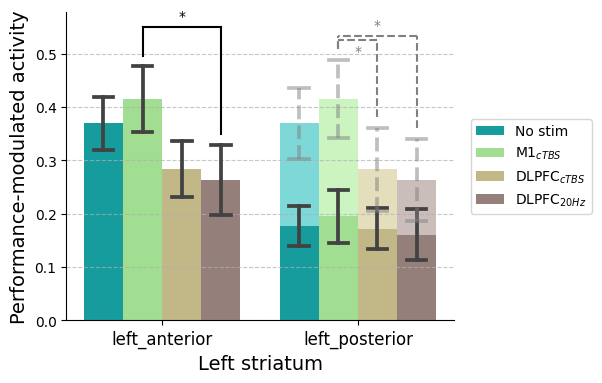

In [47]:
dict_ = {}
for legend in g.get_legend_handles_labels()[-1]:
    a = df[(df.group==legend)&(df.roi=='left_anterior')].beta
    b = df[(df.group==legend)&(df.roi=='left_posterior')].beta
    mean = (a-b).mean()
    std = (a-b).std()
    dy = std*0.5

    ref_bottom = dict_line[(legend, 'left_posterior', 'bottom')].get_bbox()
    x0 = ref_bottom.x0
    x1 = ref_bottom.x1
    xm = (x0+x1)*0.5

    ref_mid = dict_line[(legend, 'left_posterior', 'mid')].get_bbox()
    h = (ref_mid.y0+ref_mid.y1)*0.5 + mean

    width = dict_line[(legend, 'left_posterior', 'mid')].get_linewidth()

    mid = [[xm,xm],[h-dy,h+dy]]
    g.add_line(lines.Line2D(mid[0], mid[1], color='gray', alpha=0.5, linewidth=width, linestyle='--'))
    bottom = [[x0,x1],[h-dy,h-dy]]
    g.add_line(lines.Line2D(bottom[0], bottom[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))
    top = [[x0,x1],[h+dy,h+dy]]
    dict_[legend] = top
    g.add_line(lines.Line2D(top[0], top[1], color='gray', alpha=0.5, linewidth=width, linestyle='-'))

## t test
N = 4
yApart = [-0.02, 0.02]
tmp = [0.525, 0.533]

g2 = 'M1_cTBS'
for ii, g1 in enumerate(['dlPFC_cTBS', 'dlPFC_20Hz']):
    a = df[(df.group==g1)&(df.roi=='left_anterior')].beta
    b = df[(df.group==g1)&(df.roi=='left_posterior')].beta

    c = df[(df.group==g2)&(df.roi=='left_anterior')].beta
    d = df[(df.group==g2)&(df.roi=='left_posterior')].beta
    tval, pval = stats.ranksums(
        (a-b).values.astype(float), (c-d).values.astype(float)
        , alternative='less'
    )

    x1 = (dict_[g1][0][0]+dict_[g1][0][1])*0.5
    x2 = (dict_[g2][0][0]+dict_[g2][0][1])*0.5
    
    yUEdge = tmp[ii]
    g.plot([x1, x1], [dict_[g1][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x2, x2], [dict_[g2][1][0]+0.02, yUEdge], color='gray', linestyle='--')
    g.plot([x1, x2], [yUEdge, yUEdge], color='gray', linestyle='--')
    g.text(
        (x1+x2)*0.5, yUEdge+yApart[ii], convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='gray'
    )

fig

In [48]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig_3-b.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = 'tight'
)